<a href="https://colab.research.google.com/github/wylhtydtm/Nematode-project/blob/master/MarkovTransitionField_overfitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import tables
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import time
import copy
import sys

In [ ]:
!pip install pyts
import matplotlib.pyplot as plt
from pyts.image import MarkovTransitionField

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

In [ ]:
class timeseries_dataset(Dataset):

    def __init__(self, hdf5_filename, which_set='train', transform=None):

        self.fname = hdf5_filename
        self.set_name = which_set
        # get labels info
        with tables.File(self.fname, 'r') as fid:
            tmp = pd.DataFrame.from_records(
                fid.get_node('/'+self.set_name)['labels'].read())
        self.label_info = tmp[['imaging_plate_drug_concentration', 'MOA_group', 'ts_id']]
        # any transform?
        self.transform = transform

    def __len__(self):
        return len(self.label_info)

    def __getitem__(self, index):
        # I could just use index because ts_id is the same as the index of label_info, but just in case of shuffling...
        label_info = self.label_info.iloc[index]
        ts_id = label_info['ts_id'].astype(int)
        labels = label_info['MOA_group']
        labels = np.array(labels, dtype=np.float32).reshape(-1, 1)
        labels = torch.from_numpy(labels)    

        with tables.File(self.fname, 'r') as fid:
          timeseries_data = fid.get_node('/' + self.set_name + '/tw_data')[ts_id,:,:].copy()    
        ts=timeseries_data.T
        mtf = MarkovTransitionField(image_size=128,n_bins=2)
        ts= mtf.fit_transform(ts)    
        ts = torch.from_numpy(ts)
        return ts, labels

In [ ]:
hd = Path('/content/drive/My Drive')
fname = hd / 'speed_for_markovetransition_new1.hdf'
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
tw_transform= transforms.ToTensor()

In [ ]:
train_data = timeseries_dataset(fname, which_set='train') #transform=tw_transform)
val_data = timeseries_dataset(fname, which_set='val') #transform=tw_transform)

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=1)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, num_workers=1)
    

In [ ]:
with tables.File(fname, 'r') as fid:
  timeseries_data = fid.get_node(
       '/' + 'val' + '/tw_data')[:,:,:].copy()

In [ ]:
with tables.File(self.fname, 'r') as fid:
  tmp = pd.DataFrame.from_records(fid.get_node('/'+self.set_name)['labels'].read())

In [ ]:
 x=np.where(np.var(timeseries_data, axis=1) == 0)[0]
 print(x) #giving errors

In [ ]:
 x=np.where(np.var(timeseries_data, axis=1) == 0)[0]
 print(x)

In [ ]:
mtf = MarkovTransitionField(image_size=40)
X_mtf = mtf.fit_transform(train_data[0])

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(X_mtf[0], cmap='rainbow', origin='lower')
plt.title('Markov Transition Field', fontsize=18)
plt.colorbar(fraction=0.0457, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
print(timeseries_data.shape)

In [ ]:
images, labels= next(iter(train_loader)) 
images[1].shape

torch.Size([1, 128, 128])

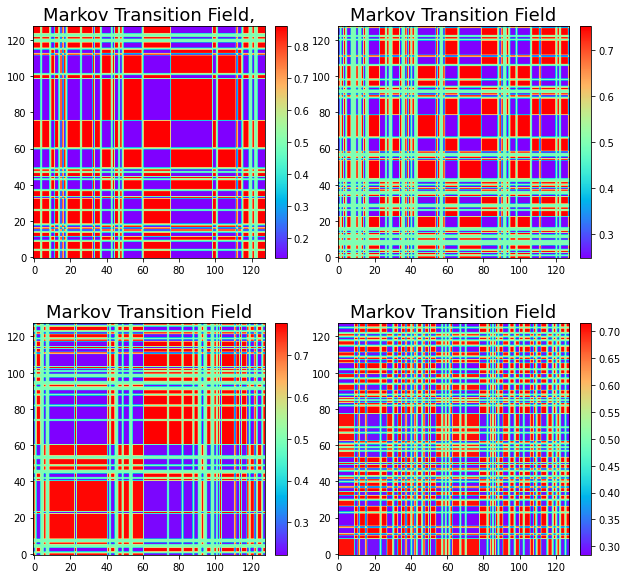

In [ ]:
# Show the results for the first four time series
plt.figure(figsize=(10, 10))
plt.tight_layout()

plt.subplot(221),plt.imshow(images[0][0], cmap='rainbow', origin='lower'),plt.title('Markov Transition Field,', fontsize=18),plt.colorbar(fraction=0.0457, pad=0.04)
plt.subplot(222), plt.imshow(images[1][0], cmap='rainbow', origin='lower'),plt.title('Markov Transition Field', fontsize=18),plt.colorbar(fraction=0.0457, pad=0.04)
plt.subplot(223),plt.imshow(images[2][0], cmap='rainbow', origin='lower'),plt.title('Markov Transition Field', fontsize=18),plt.colorbar(fraction=0.0457, pad=0.04)
plt.subplot(224),plt.imshow(images[3][0], cmap='rainbow', origin='lower'),plt.title('Markov Transition Field', fontsize=18),plt.colorbar(fraction=0.0457, pad=0.04)


plt.show()



In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(), # activation layer
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),# conv layer taking the output of the previous layer
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
                
        self.drop_out = nn.Dropout2d(0.4)
        self.fc_layers =nn.Sequential(nn.Linear(21632, 7))# define fully connected layer
    
    def forward(self, x):
        x = self.conv_layers(x) # pass input through conv layers
        x = self.drop_out(x)  
        x = x.view(x.shape[0], -1) # flatten output for fully connected layer, batchize,-1 do whatever it needs to be 
        x = self.fc_layers(x)# pass  through fully connected layer #
        return x 

In [ ]:
learning_rate = 0.0001
epochs = 200

cnn = ConvNet().to(device)# to instantiate model
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr= learning_rate)

In [ ]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
dataset_sizes = {'train':len(train_loader.dataset), 'validation':len(val_loader.dataset)}

In [ ]:
def train_model(model, criterion, optimiser, epochs, verbose= True, tag ='Loss/Train'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.float()

    Liveloss= PlotLosses()
    #Iterate through epochs
    for epoch in range(epochs):
        logs = {}
        print('Epoch{}/{}'.format(epoch, epochs-1))
        print('-' * 15)

        
        #Each epoch has a training and validation phase        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
              
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for index, (inputs, labels) in enumerate (dataloaders[phase]):
                inputs,labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1) # flatten
                labels = labels.long()
                inputs = inputs.float()
                prediction= model(inputs)
                prediction = prediction.view(labels.size(0), -1)  #flatten
                loss = criterion(prediction, labels) #calculate the loss between predicted and ground truth
                optimiser.zero_grad()
                  
                if phase == 'train':
                    if verbose: print('Epoch:', epoch, '\tBatch:', index, '\tLoss', loss.item())
                    loss.backward()  
                    optimiser.step() # backward + optimize only if in training phase

                _, pred = torch.max(prediction, dim= 1)                  
                running_loss += loss.detach() * inputs.size(0) 
                running_corrects += torch.sum(pred == labels.data)

             # calculate average losses fo the entire epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                
            logs[prefix + ' loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
                    
            #Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

        Liveloss.update(logs)
        Liveloss.send()

    time_elapse = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapse // 60, time_elapse % 60))
    print('Best Val Acc: {}'.format(best_acc)) 
    model.load_state_dict(best_model_wts)
    return model

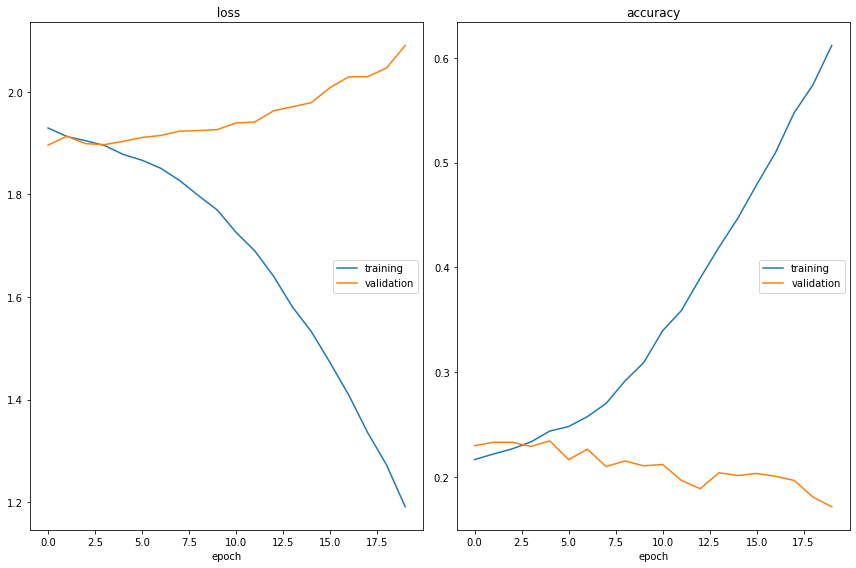

 loss
	training         	 (min:    1.191, max:    1.929, cur:    1.191)
	validation       	 (min:    1.896, max:    2.090, cur:    2.090)
accuracy
	training         	 (min:    0.216, max:    0.612, cur:    0.612)
	validation       	 (min:    0.171, max:    0.234, cur:    0.171)
Epoch20/199
---------------
Epoch: 20 	Batch: 0 	Loss 1.0592448711395264
Epoch: 20 	Batch: 1 	Loss 0.9019389152526855
Epoch: 20 	Batch: 2 	Loss 0.9905738830566406
Epoch: 20 	Batch: 3 	Loss 1.105398178100586
Epoch: 20 	Batch: 4 	Loss 1.1640263795852661
Epoch: 20 	Batch: 5 	Loss 1.176161766052246
Epoch: 20 	Batch: 6 	Loss 1.0278117656707764
Epoch: 20 	Batch: 7 	Loss 1.1592528820037842
Epoch: 20 	Batch: 8 	Loss 1.0114043951034546
Epoch: 20 	Batch: 9 	Loss 1.052813172340393
Epoch: 20 	Batch: 10 	Loss 1.1143689155578613
Epoch: 20 	Batch: 11 	Loss 1.1371407508850098
Epoch: 20 	Batch: 12 	Loss 0.9660347700119019
Epoch: 20 	Batch: 13 	Loss 1.0489498376846313
Epoch: 20 	Batch: 14 	Loss 1.0728646516799927
Epoch: 20 	Batch

In [ ]:
cnn = train_model(cnn, criterion, optimiser, epochs)